In [5]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import rasterio
from rasterio.plot import show
from bs4 import BeautifulSoup

In [6]:
#Initializing file names and station cordinates
path = 'C:/Users/Shubham/Desktop/BTP/'
locs = np.array([[22.62787245,88.38065471],[22.54452891,88.34070086],[22.55698815,88.34256888],[22.4992859,88.36915952],[22.51140591,88.35134291],[22.58069355,88.41112286],[22.53585873,88.36431757]])

In [7]:
#Defining Function to get Atmospheric reflectance of stations from satellite images
def get_ref(name):
    b = []
    with open(path+name+'/'+name+'_MTL.xml', 'r') as f:
        data = f.read()
    Bs_data = BeautifulSoup(data, "xml")
    upper = (float(Bs_data.find('CORNER_UL_LAT_PRODUCT').text)+float(Bs_data.find('CORNER_UR_LAT_PRODUCT').text))/2
    lower = (float(Bs_data.find('CORNER_LL_LAT_PRODUCT').text)+float(Bs_data.find('CORNER_LR_LAT_PRODUCT').text))/2
    right = (float(Bs_data.find('CORNER_LR_LON_PRODUCT').text)+float(Bs_data.find('CORNER_UR_LON_PRODUCT').text))/2
    left = (float(Bs_data.find('CORNER_LL_LON_PRODUCT').text)+float(Bs_data.find('CORNER_UL_LON_PRODUCT').text))/2
    coordi = []
    for loc in locs:
        y = float(Bs_data.find('CORNER_LL_PROJECTION_Y_PRODUCT').text) + ((float(Bs_data.find('CORNER_UL_PROJECTION_Y_PRODUCT').text) - float(Bs_data.find('CORNER_LL_PROJECTION_Y_PRODUCT').text))/(upper -lower )*(loc[0] - lower))
        x = float(Bs_data.find('CORNER_LL_PROJECTION_X_PRODUCT').text) +((float(Bs_data.find('CORNER_LR_PROJECTION_X_PRODUCT').text) - float(Bs_data.find('CORNER_LL_PROJECTION_X_PRODUCT').text))/(right-left)*(loc[1] - left))
        row = int(Bs_data.find('REFLECTIVE_LINES').text) - int((y - float(Bs_data.find('CORNER_LL_PROJECTION_Y_PRODUCT').text))/30)
        col = int((x - float(Bs_data.find('CORNER_LL_PROJECTION_X_PRODUCT').text))/30)
        coordi.append([row,col])
    for i in range(1,5):
        fpb = path+name+'/'+name+'_SR_B'+str(i)+'.tif' 
        b_img = rasterio.open(fpb)
        arr = b_img.read(1)
        a = []
        for j in coordi:
            sr = (arr[j[0],j[1]]*float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_MULT_BAND_'+str(i)).text)+float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_ADD_BAND_'+str(i)).text))
            toa = (arr[j[0],j[1]]*float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_MULT_BAND_'+str(i)).text)+float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_ADD_BAND_'+str(i)).text))/np.sin(math.radians(float(Bs_data.find('SUN_ELEVATION').text)))
            ar = toa - sr
            a.append(ar)
        b.append(a)
    return b[0],b[1],b[2],b[3]

    

In [8]:
#Getting Atmospheric reflectances of 4 bands
band1 = []
band2 = []
band3 = []
band4 = []
dates = ['LC08_L2SP_138044_20210103_20210308_02_T1','LC08_L2SP_138044_20210119_20210307_02_T1','LC08_L2SP_138044_20210204_20210303_02_T1','LC08_L2SP_138044_20210425_20210501_02_T1','LC08_L2SP_138044_20211103_20211109_02_T1','LC08_L2SP_138044_20211119_20211125_02_T1','LC08_L2SP_138044_20211221_20211229_02_T1','LC09_L2SP_138044_20211213_20220120_02_T1']
for date in dates:
    b1,b2,b3,b4 = get_ref(date)
    band1.append(b1)
    band2.append(b2)
    band3.append(b3)
    band4.append(b4)

In [9]:
#Converting the lists to arrays
band1 = np.array(band1).flatten()
band2 = np.array(band2).flatten()
band3 = np.array(band3).flatten()
band4 = np.array(band4).flatten()

In [10]:
#Load the Ground Measured pm10 data
df = pd.read_excel('pm10_data.xlsx')

In [11]:
#Adding the Atmospheric reflectances of 4 bands to the dataset
df['band_1'] = band1*100
df['band_2'] = band2*100
df['band_3'] = band3*100
df['band_4'] = band4*100

In [12]:
#Visualizing the dataset
df.head()

,Date,Location,PM10,band_1,band_2,band_3,band_4
0,2021-01-03,"Rabindra Bharati University, Kolkata - WBPCB",341.88,8.325976,8.509627,8.820642,8.879792
1,2021-01-03,"Victoria, Kolkata - WBPCB",304.66,8.324068,8.518214,8.941327,9.123071
2,2021-01-03,"Fort William, Kolkata - WBPCB",297.60,8.059324,8.373678,8.920339,8.723808
3,2021-01-03,"Jadavpur, Kolkata - WBPCB",315.64,8.132307,8.375109,8.754337,8.806332
4,2021-01-03,"Rabindra Sarobar, Kolkata - WBPCB",299.00,8.131830,8.283521,8.541110,8.527754


In [13]:
#Printing the Linear Correlation value of Measured PM10 with different bands
print(scipy.stats.pearsonr(df['PM10'], band1))
print(scipy.stats.pearsonr(df['PM10'], band2))
print(scipy.stats.pearsonr(df['PM10'], band3))
print(scipy.stats.pearsonr(df['PM10'], band4))


(0.7456802710939398, 4.3002656337945345e-11)
(0.7544666202860895, 1.8849741577081527e-11)
(0.7648917360720296, 6.767238502466436e-12)
(0.766175200967663, 5.943766483376018e-12)


array([[<AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'band_1'}>],
       [<AxesSubplot:title={'center':'band_2'}>,
        <AxesSubplot:title={'center':'band_3'}>],
       [<AxesSubplot:title={'center':'band_4'}>, <AxesSubplot:>]],
      dtype=object)

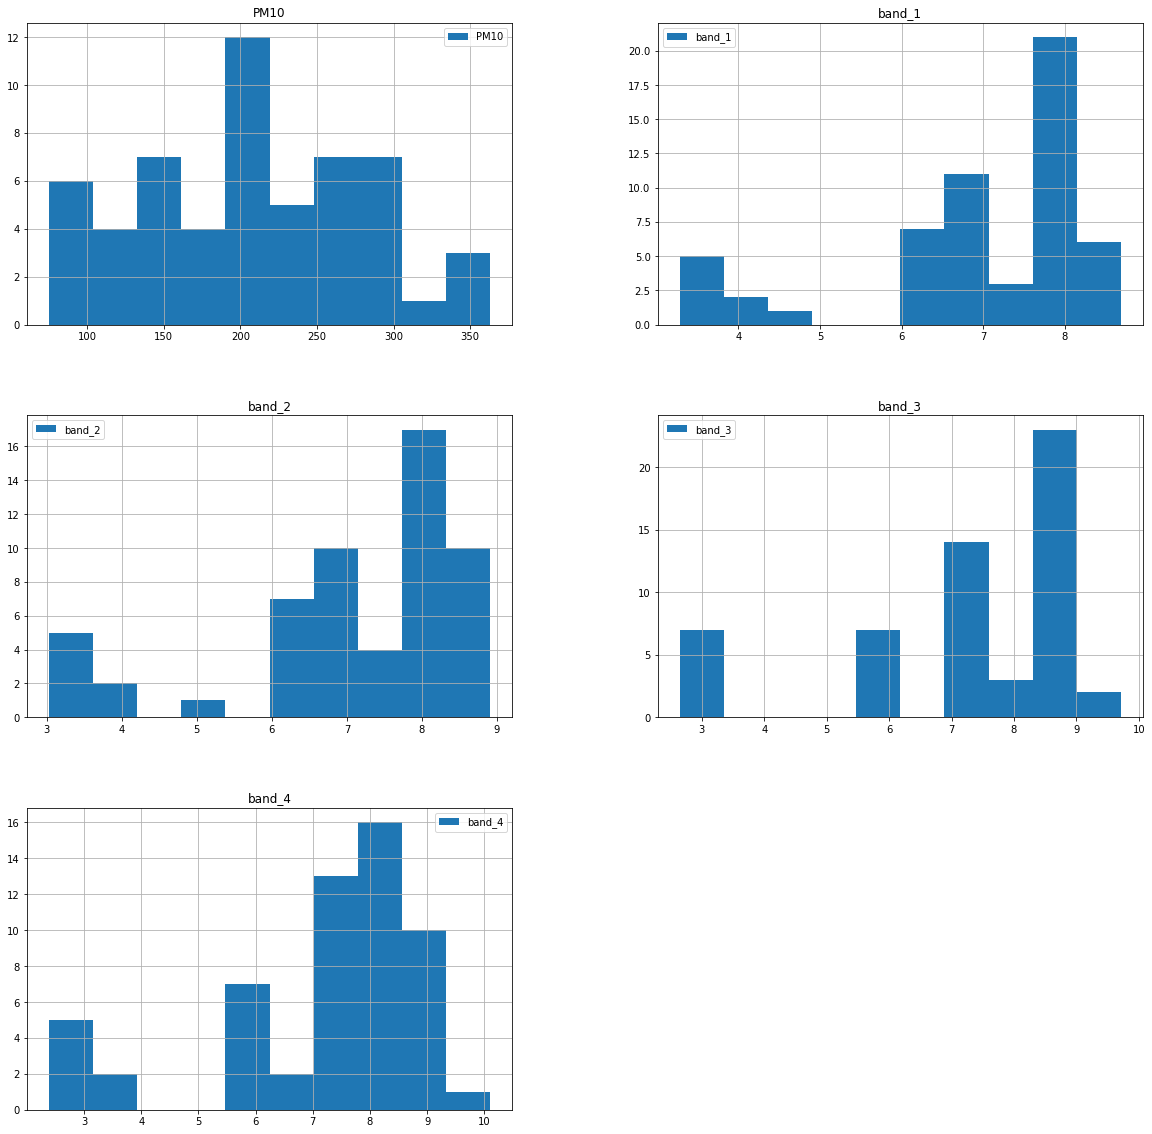

In [10]:
#Visualizing the distribution of data in diffferent columns
df.hist(figsize=(20,20),legend=True)

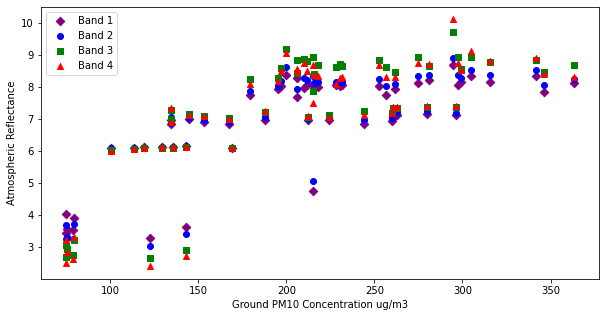

In [15]:
#Plotting the Atmospheric reflectance values with Ground Measured data
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['PM10'], df['band_1'],color='purple',marker = 'D',label = 'Band 1')
ax.scatter(df['PM10'], df['band_2'],color='blue',marker = 'o',label = 'Band 2')
ax.scatter(df['PM10'], df['band_3'],color='green',marker = 's',label = 'Band 3')
ax.scatter(df['PM10'], df['band_4'],color='red',marker = '^',label = 'Band 4')
ax.legend()
ax.set_xlabel('Ground PM10 Concentration ug/m3')
ax.set_ylabel('Atmospheric Reflectance')
fig = ax.get_figure()
fig.savefig(path+'Images/atvsPM10.png',facecolor=ax.get_facecolor(), edgecolor='none')

In [16]:
#Modifying the dataset to train different models 
X = []
X1 = df[df.columns[3]]
X.append(X1.values.reshape(-1,1))
X2 = df[df.columns[4]]
X.append(X2.values.reshape(-1,1))
X3 = df[df.columns[5]]
X.append(X3.values.reshape(-1,1))
X4 = df[df.columns[6]]
X.append(X4.values.reshape(-1,1))
X5 = df[[df.columns[3],df.columns[4]]]
X.append(X5)
X6 = df[[df.columns[3],df.columns[5]]]
X.append(X6)
X7 = df[[df.columns[3],df.columns[6]]]
X.append(X7)
X8 = df[[df.columns[4],df.columns[5]]]
X.append(X8)
X9 = df[[df.columns[4],df.columns[6]]]
X.append(X9)
X10 = df[[df.columns[5],df.columns[6]]]
X.append(X10)
X11 = df[[df.columns[3],df.columns[4],df.columns[5]]]
X.append(X11)
X12 = df[[df.columns[3],df.columns[4],df.columns[6]]]
X.append(X12)
X13 = df[[df.columns[3],df.columns[5],df.columns[6]]]
X.append(X13)
X14 = df[[df.columns[4],df.columns[5],df.columns[6]]]
X.append(X14)
X15 = df[df.columns[3:7]]
X.append(X15)
y = df['PM10']

In [17]:
#Fitting the data in the models
linreg = []
y_preds = []
coeffs = []
intercept = []
R = []
RMSE = []

for x in X:
    reg = LinearRegression().fit(x,y)
    linreg.append(reg)
    y_pred = reg.predict(x)
    y_preds.append(y_pred)
    coeff = reg.coef_
    coeffs.append(coeff)
    intercept.append(reg.intercept_)
    R.append(scipy.stats.pearsonr(y,y_pred))
    MSE = mean_squared_error(y,y_pred)
    RMSE.append(math.sqrt(MSE))
    

In [18]:
lreg = LinearRegression().fit(y.values.reshape(-1,1),y_preds[14])

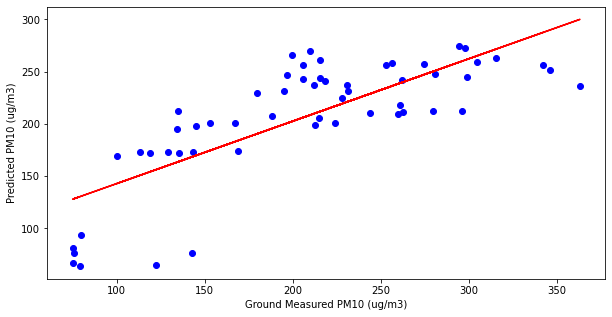

In [19]:
#Visualizing Original PM10 data vs Predicted PM10 data
figure1, ax =plt.subplots(figsize= (10, 5))
ax.scatter(y,y_preds[14], color='blue')
y_axis = y*lreg.coef_+lreg.intercept_
ax.plot(y,y_axis,color='red')
ax.set_xlabel('Ground Measured PM10 (ug/m3)')
ax.set_ylabel('Predicted PM10 (ug/m3)')
fig = ax.get_figure()
fig.savefig(path+'Images/groundvspredicted.png',facecolor=ax.get_facecolor(), edgecolor='none')

In [20]:
r2_score(y,y_preds[14])

0.5971613514758818

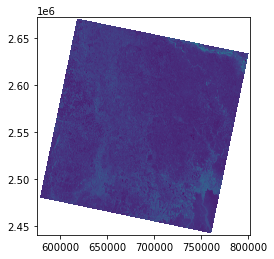

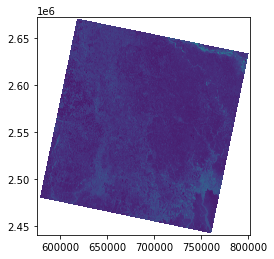

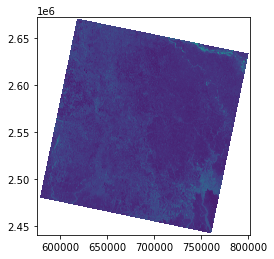

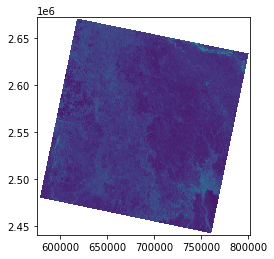

<AxesSubplot:>

In [22]:
fp1 = path+'LC09_L2SP_138044_20220319_20220323_02_T1/LC09_L2SP_138044_20220319_20220323_02_T1_SR_B1.tif'
fp2 = path+'LC09_L2SP_138044_20220319_20220323_02_T1/LC09_L2SP_138044_20220319_20220323_02_T1_SR_B2.tif'
fp3 = path+'LC09_L2SP_138044_20220319_20220323_02_T1/LC09_L2SP_138044_20220319_20220323_02_T1_SR_B3.tif'
fp4 = path+'LC09_L2SP_138044_20220319_20220323_02_T1/LC09_L2SP_138044_20220319_20220323_02_T1_SR_B4.tif'
img1 = rasterio.open(fp1)
img2 = rasterio.open(fp2)
img3 = rasterio.open(fp3)
img4 = rasterio.open(fp4)
show(img1)
show(img2)
show(img3)
show(img4)

In [23]:
b1 = img1.read(1)
b2 = img2.read(1)
b3 = img3.read(1)
b4 = img4.read(1)

In [24]:
b1.shape

(7701, 7561)

In [26]:
with open(path+'LC09_L2SP_138044_20220319_20220323_02_T1/LC09_L2SP_138044_20220319_20220323_02_T1_MTL.xml', 'r') as f:
    data = f.read()
Bs_data = BeautifulSoup(data, "xml")    
upper = (float(Bs_data.find('CORNER_UL_LAT_PRODUCT').text)+float(Bs_data.find('CORNER_UR_LAT_PRODUCT').text))/2
lower = (float(Bs_data.find('CORNER_LL_LAT_PRODUCT').text)+float(Bs_data.find('CORNER_LR_LAT_PRODUCT').text))/2
right = (float(Bs_data.find('CORNER_LR_LON_PRODUCT').text)+float(Bs_data.find('CORNER_UR_LON_PRODUCT').text))/2
left = (float(Bs_data.find('CORNER_LL_LON_PRODUCT').text)+float(Bs_data.find('CORNER_UL_LON_PRODUCT').text))/2


In [27]:
x1 = 22.758747345361655
y1 = 88.19421149557328
x2 = 22.447673426389958
y2 = 88.51619215275937


In [28]:
u = int((upper-x1)/(upper-lower)*7701)
l = int((upper-x2)/(upper-lower)*7701)
le = int((y1-left)/(right-left)*7561)
r = int((y2-left)/(right-left)*7561)

In [29]:
kb1 = b1[u:l,le:r]
sr1 = (kb1*float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_ADD_BAND_1').text))
toa1 = (kb1*float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_ADD_BAND_1').text))/np.sin(math.radians(float(Bs_data.find('SUN_ELEVATION').text)))
ar1 = (toa1 - sr1)*100

kb2 = b2[u:l,le:r]
sr2 = (kb2*float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_ADD_BAND_1').text))
toa2 = (kb2*float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_ADD_BAND_1').text))/np.sin(math.radians(float(Bs_data.find('SUN_ELEVATION').text)))
ar2 = (toa2 - sr2)*100

kb3 = b3[u:l,le:r]
sr3 = (kb3*float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_ADD_BAND_1').text))
toa3 = (kb3*float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_ADD_BAND_1').text))/np.sin(math.radians(float(Bs_data.find('SUN_ELEVATION').text)))
ar3 = (toa3 - sr3)*100

kb4 = b4[u:l,le:r]
sr4 = (kb4*float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL2_SURFACE_REFLECTANCE_PARAMETERS').find('REFLECTANCE_ADD_BAND_1').text))
toa4 = (kb4*float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_MULT_BAND_1').text)+float(Bs_data.find('LEVEL1_RADIOMETRIC_RESCALING').find('REFLECTANCE_ADD_BAND_1').text))/np.sin(math.radians(float(Bs_data.find('SUN_ELEVATION').text)))
ar4 = (toa4 - sr1)*100

In [30]:
PM10 = coeffs[14][0]*ar1 + coeffs[14][1]*ar2 + coeffs[14][2]*ar3 + coeffs[14][3]*ar4 + intercept[14]


<ipython-input-32-4881ec12a7fb>:7: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  pixel_plot.add_axes()


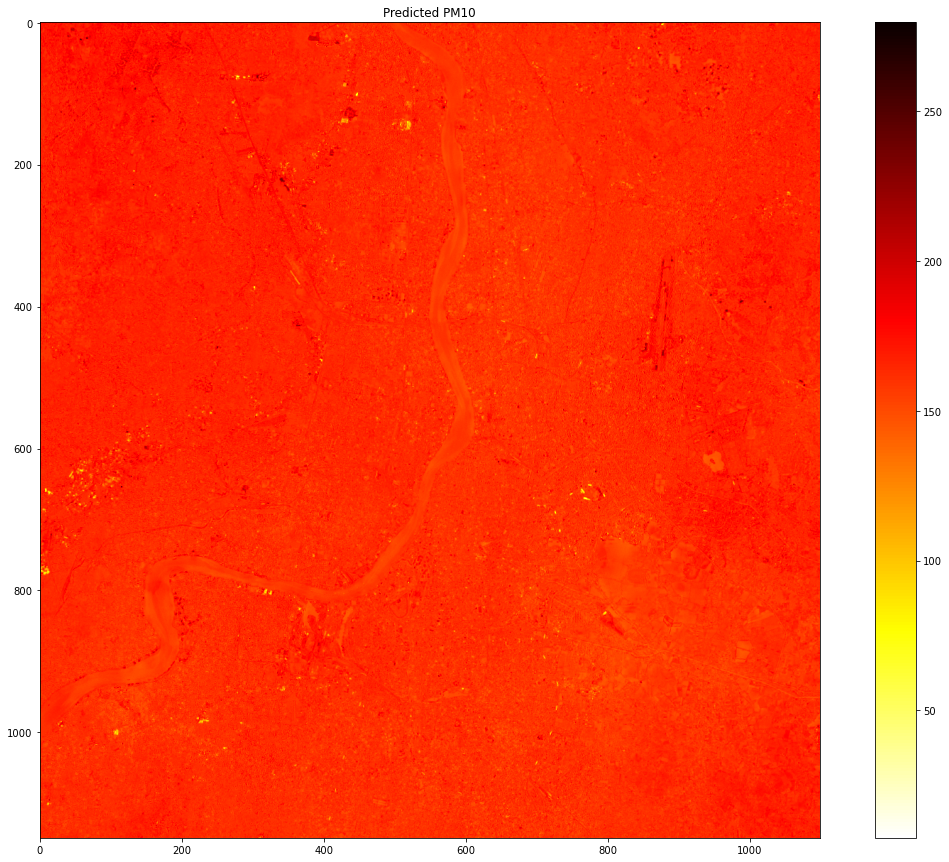

In [32]:
#Plotting the PM10 Map of Kolkata dated 19th March 2022 using the model
pixel_plot = plt.figure()
pixel_plot.set_figwidth(20)
pixel_plot.set_figheight(15)
  
# plotting a plot
pixel_plot.add_axes()
  
# customizing plot
plt.title("Predicted PM10")
pixel_plot = plt.imshow(PM10,cmap='hot_r')
  
plt.colorbar(pixel_plot)
plt.savefig(path+'Images/PredictedPM10.png',facecolor=ax.get_facecolor(), edgecolor='none')
  